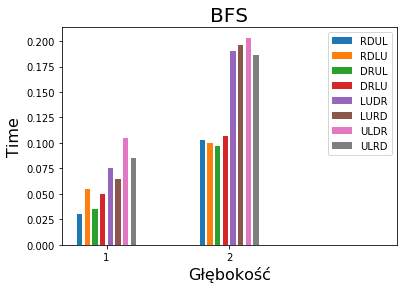

In [8]:
import os
from itertools import permutations 
from matplotlib import pyplot as plot
import numpy as np

stats = ("length", "visitedStates", "processedStates", "depth", "time")
strategies = ("bfs", "dfs", "astr")
lrudVariants = ("RDUL", "RDLU", "DRUL", "DRLU", "LUDR", "LURD", "ULDR", "ULRD")
#lrudVariants = ("".join(perm) for perm in permutations("LRUD"))
astrVariants = ("hamm", "manh")

def packFilename(filename, strategy, variant, type):
	name, extension = os.path.splitext(filename)
	return "{}_{}_{}_{}{}".format(name, strategy, variant, type, extension)

def unpackFilename(filename):
	name, extension = os.path.splitext(filename)
	puzzleSize, iterations, puzzleId, strategy, variant, type = name.split("_") 
	return iterations, strategy, variant, type

def mean(x):
	length = len(x)
	if length != 0:
		return sum(x) / length
	else:
		return 0

def solvePuzzles(puzzlesDirectory, solutionsDirectory, statsDirectory):
	variants = []
	for filename in os.listdir(puzzlesDirectory):
		for strategy in strategies:
			if strategy == "astr":
				variants = astrVariants
			else:
				variants = lrudVariants
			for variant in variants:
				os.system("python main.py {} {} {} {} {}".format
				(
					strategy,
					variant,
					os.path.join(puzzlesDirectory, filename),
					os.path.join( solutionsDirectory, packFilename(filename, strategy, variant, "sol" ) ),
					os.path.join( statsDirectory, packFilename(filename, strategy, variant, "stats") )
				))

def dictUpdate(dict, argument):
	dict.update(argument)
	return dict

def listAppend(list, argument):
	list.append(argument)
	return list

def loadStats(statsDirectory, iterations):
	bfsStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in lrudVariants} ) for stat in stats})
	dfsStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in lrudVariants} ) for stat in stats})
	astrStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in astrVariants} ) for stat in stats})
	for filename in os.listdir(statsDirectory):
		iterations, strategy, variant, type = unpackFilename(filename)
		iterations = int(iterations)
		with open(os.path.join(statsDirectory, filename), 'r') as f:
			for stat in stats:
				value = f.readline()
				if stat != "time":
					value = int(value)
				else:
					value = float(value)
				if strategy == "bfs":
					bfsStats[stat][variant][iterations].append(value)
				elif strategy == "dfs":
					dfsStats[stat][variant][iterations].append(value)
				else:
					astrStats[stat][variant][iterations].append(value)
	return bfsStats, dfsStats, astrStats

def calculateMeans(stats):
	for stat in stats.values():
		for variant in stat.values():
			for key, iter in variant.items():
				variant[key] = mean(iter)

def combineGlobalMeansStats(bfsStats, dfsStats, astrStats, iterations):
	globalStats = dictUpdate({}, {stat:dictUpdate({}, {strategy:dictUpdate({}, {it:0 for it in range(1, iterations + 1)}) for strategy in strategies} ) for stat in stats})
	for statKey, statVal in globalStats.items():
		for strategyKey, strategyVal in statVal.items():
			for iterKey, iterVal in strategyVal.items():
				if strategyKey == "bfs":
					strategyVal[iterKey] = mean([bfsStats[statKey][variant][iterKey] for variant in lrudVariants])
				elif strategyKey == "dfs":
					strategyVal[iterKey] = mean([dfsStats[statKey][variant][iterKey] for variant in lrudVariants])
				elif strategyKey == "astr":
					strategyVal[iterKey] = mean([astrStats[statKey][variant][iterKey] for variant in astrVariants])
	return globalStats

'''
def barPlot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """
	Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plot.rcParams['axes.prop_cycle'].by_key()['color']
    # Number of bars per group
    n_bars = len(data)
    # The width of a single bar
    bar_width = total_width / n_bars
    # List containing handles for the drawn bars, used for the legend
    bars = []
    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
		# Transform this weird dictionary into list
		values = list(values.values())
        # The offset in x direction of that bar
		x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        # Draw a bar for every value of that type
		for x, y in enumerate(values):
			bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
        # Add a handle to the last drawn bar, which we'll need for the legend
		bars.append(bar[0])
	
	# Draw legend if we need
	if legend:
		ax.legend(bars, data.keys())
'''

def barPlot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
	if colors is None:
		colors = plot.rcParams['axes.prop_cycle'].by_key()['color']
	n_bars = len(data)
	bar_width = total_width / n_bars
	bars = []
	for i, (name, values) in enumerate(data.items()):
		values = list(values.values())
		x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
		for x, y in enumerate(values):
			bar = ax.bar((x + 1) + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
		bars.append(bar[0])
	if legend:
		ax.legend(bars, data.keys())

#solvePuzzles("wikamp/puzzles", "wikamp/solutions", "wikamp/stats")
bfsStats, dfsStats, astrStats = loadStats("wikamp/stats", 3)

calculateMeans(bfsStats)
calculateMeans(dfsStats)
calculateMeans(astrStats)
globalStats = combineGlobalMeansStats(bfsStats, dfsStats, astrStats, 3)

fig, ax = plot.subplots()
barPlot(ax, bfsStats["time"], total_width=.5, single_width=.7)
plot.xticks(np.arange(1, 3, 1))
plot.title("BFS", fontsize=20)
plot.ylabel("Time", fontsize=16)
plot.xlabel("Głębokość", fontsize=16) 
plot.show()
